In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)

import sys
sys.path.insert(0, '../src/')

import methods
import time

## Generate ill-conditioned matrix, ```eps_cond``` controls condition number 

In [2]:
m = 10000
n = 100
eps_cond = 1e-6
seed = 42
np.random.seed(seed)

A = np.random.randn(m, n)
U, s, V = np.linalg.svd(A, full_matrices=False)
A = U.dot(np.diag(np.maximum(s - np.min(s) + eps_cond, 0))).dot(V)
s = np.linalg.svd(A, compute_uv=False, full_matrices=False)
print("Cond number = {}".format(max(s) / min(s)))
kappa = np.linalg.norm(A, "fro") / min(s)
print("Convergence factor for a consistent linear system = {}".format(kappa))
x_true = np.random.randn(n)

Cond number = 19605065.815627676
Convergence factor for a consistent linear system = 112609049.85223769


### Construct consistent or noisy linear system, control it with a noise level ```sigma```

In [3]:
sigma = 0.
b = A.dot(x_true) + sigma * np.random.randn(m)
b = b[:, np.newaxis]
print(A.shape, b.shape)

(10000, 100) (10000, 1)


## Construct preconditioners from sketched matrix

In [4]:
gamma_range = list(range(1, 5))

preprocess_time = { "PrecRKM, $\gamma = {}$".format(gamma): 0 for gamma in gamma_range}

sketch_sizes = [gamma * n for gamma in gamma_range]
P = {name: [] for name in preprocess_time}

In [5]:
# From some random submatrix
P = {}
for k, gamma in enumerate(gamma_range):
    print("Sketch size = {}".format(n * gamma))
    st = time.time()
    sketch_idx = np.sort(np.random.choice(np.arange(m), sketch_sizes[k], replace=False))
    Q, R_qr = np.linalg.qr(A[sketch_idx, :])
    P["PrecRKM, $\gamma = {}$".format(gamma)] = np.linalg.inv(R_qr)
    preprocess_time["PrecRKM, $\gamma = {}$".format(gamma)] = time.time() - st

Sketch size = 100
Sketch size = 200
Sketch size = 300
Sketch size = 400


## Defines parameters of the compared methods

In [6]:
max_iter = 300000
tol = 1e-6
x0 = np.zeros(n)
# Maximum number of seconds to run the method
max_time = 1.5
# How frequent the current iterand is stored
log_interval = 10

## Compare preconditioned Kaczmarz method with no preconditioning

In [7]:
conv_x_res = {"RKM": []}
conv_time_res = {"RKM": []}

In [8]:
res = methods.classical_kaczmarz(A, b, x0, max_iter, max_time, log_interval)
conv_x_res["RKM"] = res["conv_x"]
conv_time_res["RKM"] = res["conv_time"]

In [9]:
for name in preprocess_time:
    print(name)
    res = methods.precond_kaczmarz(A, b, P[name], 
                             x0, max_iter, max_time, 
                             log_interval, preprocess_time[name])
    conv_x_res[name] = res["conv_x"]
    conv_time_res[name] = res["conv_time"]

PrecRKM, $\gamma = 1$
PrecRKM, $\gamma = 2$
PrecRKM, $\gamma = 3$
PrecRKM, $\gamma = 4$


In [10]:
res = methods.extended_kaczmarz(A, b, x0, max_iter, max_time, log_interval)
conv_x_res["REK"] = res["conv_x"]
conv_time_res["REK"] = res["conv_time"]

In [11]:
res = methods.rdbk(A, b, x0, 10, 10, max_iter, max_time, 1)
conv_x_res["Block REK"] = res["conv_x"]
conv_time_res["Block REK"] = res["conv_time"]

In [12]:
relative_residual_norm = {}
for name in conv_x_res:
    relative_residual_norm[name] = []
    if P.get(name) is None:
        for x in conv_x_res[name]:
            relative_residual_norm[name].append(np.linalg.norm(A @ x - b) / np.linalg.norm(b))
    else:
        for x in conv_x_res[name]:
            relative_residual_norm[name].append(np.linalg.norm(A @ (P[name] @ x) - b) / np.linalg.norm(b))

## Plots
### Relative error vs. number of iterations

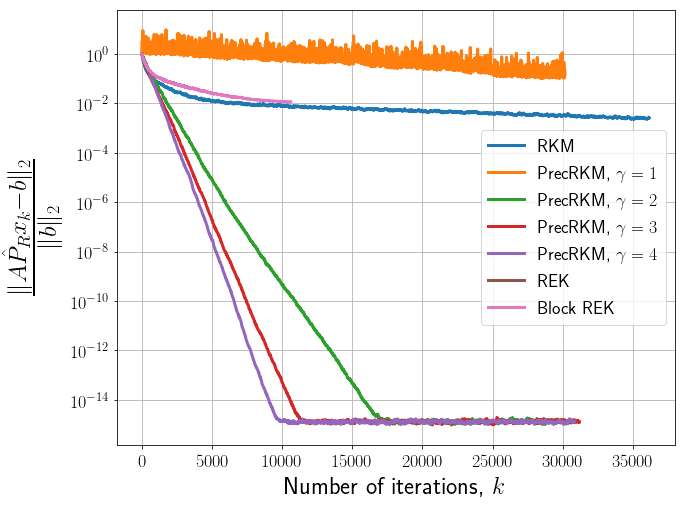

In [13]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    iter_range = [j * log_interval for j in range(len(conv_x_res[name]))]
    plt.semilogy(iter_range, relative_residual_norm[name], label=name, linewidth=3)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=36)
plt.xlabel(r"Number of iterations, $k$", fontsize=24)
plt.legend(fontsize=18)
plt.grid(True)
_ = plt.yticks(fontsize=18)
_ = plt.xticks(fontsize=18)

### Relative error vs. running time + time to construct preconditioners

RKM
PrecRKM, $\gamma = 1$
PrecRKM, $\gamma = 2$
PrecRKM, $\gamma = 3$
PrecRKM, $\gamma = 4$
REK
Block REK


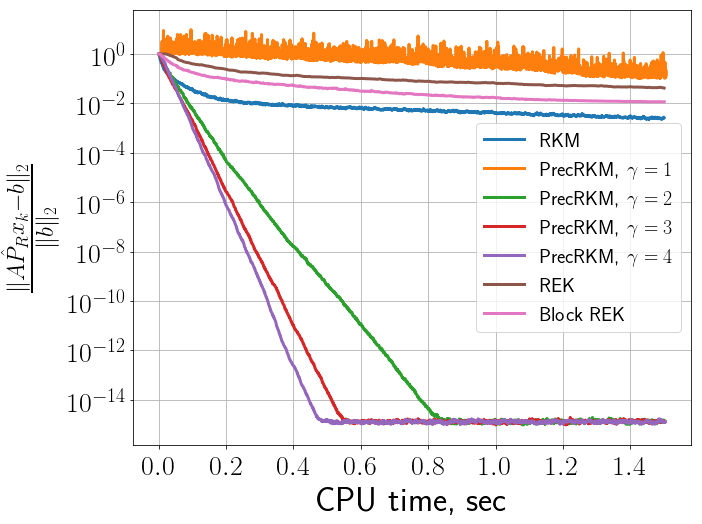

In [14]:
plt.figure(figsize=(10, 8))

for name in relative_residual_norm:
    print(name)
    if name != "Block REK":
        if conv_time_res[name][-1] == conv_time_res[name][::log_interval][-1]:
            time_range = conv_time_res[name][::log_interval]
        else:
            time_range = conv_time_res[name][::log_interval] + [conv_time_res[name][-1]]
        plt.semilogy(time_range, relative_residual_norm[name], label=name, linewidth=3)
    else:
        plt.semilogy(conv_time_res[name], relative_residual_norm[name], label=name, linewidth=3)
plt.ylabel(r"$\frac{\|A\hat{P}_Rx_k - b\|_2}{\|b\|_2}$", fontsize=34)
plt.xlabel(r"CPU time, sec", fontsize=34)
plt.legend(fontsize=20)
_ = plt.yticks(fontsize=28)
_ = plt.xticks(fontsize=28)
plt.grid(True)